In [68]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

import numpy as np
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import torch
import torch.nn as nn
from torchinfo import summary

import FrEIA.framework as Ff
import FrEIA.modules as Fm

In [292]:
def subnet_fc(c_in, c_out):
    return nn.Sequential(nn.Linear(c_in, 512), nn.GELU(),
                        nn.Linear(512,  c_out))

In [293]:
inn = Ff.SequenceINN(2)
for k in range(8):
    inn.append(Fm.AllInOneBlock, subnet_constructor=subnet_fc, permute_soft=True)

In [294]:
inn

SequenceINN(
  (module_list): ModuleList(
    (0): AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
        (0): Linear(in_features=1, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=512, out_features=2, bias=True)
      )
    )
    (1): AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
        (0): Linear(in_features=1, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=512, out_features=2, bias=True)
      )
    )
    (2): AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
        (0): Linear(in_features=1, out_features=512, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=512, out_features=2, bias=True)
      )
    )
    (3): AllInOneBlock(
      (softplus): Softplus(beta=0.5, threshold=20)
      (subnet): Sequential(
      

In [295]:
summary(inn)

Layer (type:depth-idx)                   Param #
SequenceINN                              --
├─ModuleList: 1-1                        --
│    └─AllInOneBlock: 2-1                12
│    │    └─Softplus: 3-1                --
│    │    └─Sequential: 3-2              2,050
│    └─AllInOneBlock: 2-2                12
│    │    └─Softplus: 3-3                --
│    │    └─Sequential: 3-4              2,050
│    └─AllInOneBlock: 2-3                12
│    │    └─Softplus: 3-5                --
│    │    └─Sequential: 3-6              2,050
│    └─AllInOneBlock: 2-4                12
│    │    └─Softplus: 3-7                --
│    │    └─Sequential: 3-8              2,050
│    └─AllInOneBlock: 2-5                12
│    │    └─Softplus: 3-9                --
│    │    └─Sequential: 3-10             2,050
│    └─AllInOneBlock: 2-6                12
│    │    └─Softplus: 3-11               --
│    │    └─Sequential: 3-12             2,050
│    └─AllInOneBlock: 2-7                12
│    │   

In [296]:
@torch.inference_mode()
def ll(inn, x):
    inn.eval()
    z, log_jac_det = inn(x)
    z = z.cpu().numpy()
    log_jac_det = log_jac_det.cpu().numpy()
    logpz = -0.5 * np.sum(z**2, axis=1) - log_jac_det
    return logpz, z

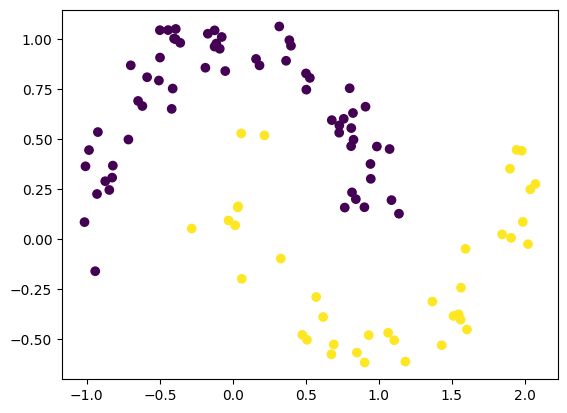

In [297]:
# Import the make  moons dataset from sklearn
from sklearn.datasets import make_moons

# Generate the dataset
X, y = make_moons(n_samples=1200, noise=0.1, random_state=42)
plt.scatter(X[:100,0], X[:100,1], c=y[:100])

In [298]:
%%time
Xin = torch.tensor(X[:3], dtype=torch.float32)
inn.cpu()
z, log_jac_det = inn(Xin)
x_inv, log_jac_det_inv = inn(z, rev=True)

assert torch.allclose(Xin, x_inv)

CPU times: user 550 ms, sys: 11.9 ms, total: 562 ms
Wall time: 29.6 ms


In [299]:
inn = inn.cuda()
X_train = torch.tensor(X[:-200], dtype=torch.float32).cuda()
X_eval = torch.tensor(X[-200:], dtype=torch.float32).cuda()
opt = torch.optim.Adam(inn.parameters(), lr=1e-3)

In [305]:
%%time
for i in tqdm(range(5000)):
    for xin in X_train.chunk(2):
        opt.zero_grad()
        z, log_jac_det = inn(xin)
        loss = torch.mean(z**2) - torch.mean(log_jac_det)
        loss.backward()
        opt.step()

100%|██████████| 5000/5000 [02:34<00:00, 32.37it/s]

CPU times: user 2min 33s, sys: 1.39 s, total: 2min 35s
Wall time: 2min 34s


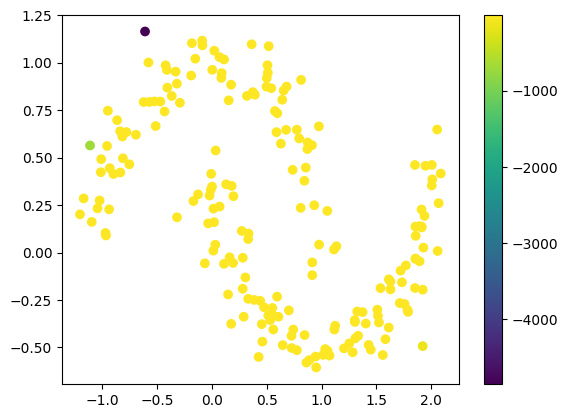

In [306]:
logpz, z = ll(inn, X_eval)
plt.scatter(X_eval.cpu()[:,0], X_eval.cpu()[:,1], c=logpz)
plt.colorbar()

In [307]:
# Build mesh grid and display densities
x = np.linspace(-1, 2, 50)
y = np.linspace(-1, 2, 50)
xx, yy = np.meshgrid(x, y)

Xgrid = np.concatenate([xx.reshape(-1, 1), yy.reshape(-1, 1)], axis=1)
Xgrid = torch.tensor(Xgrid, dtype=torch.float32).cuda()
logpz, z = ll(inn, Xgrid)

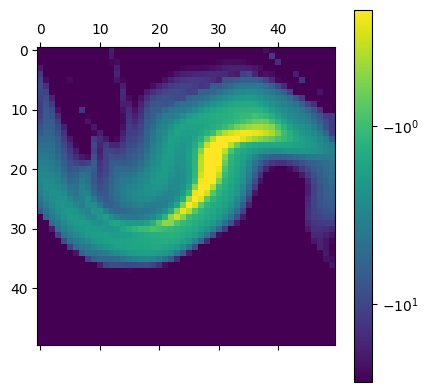

In [308]:
plt.matshow(logpz.reshape(50,50), norm=colors.SymLogNorm(
    linthresh=1, vmin=np.quantile(logpz,0.5), vmax=np.quantile(logpz,0.99)))
plt.colorbar()

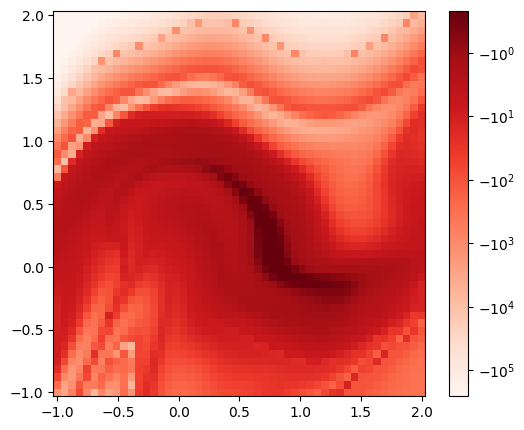

In [309]:
# Plot the densities on the grid
import matplotlib.colors as colors
fig, ax = plt.subplots(figsize=(6, 5))
p = ax.pcolormesh(xx,yy, logpz.reshape(50, 50), norm=colors.SymLogNorm(linthresh=1,
    vmin=np.quantile(logpz,0.01), vmax=np.quantile(logpz,0.99)),
    antialiased=False, cmap='Reds', linewidth=0, rasterized=True)
fig.colorbar(p)

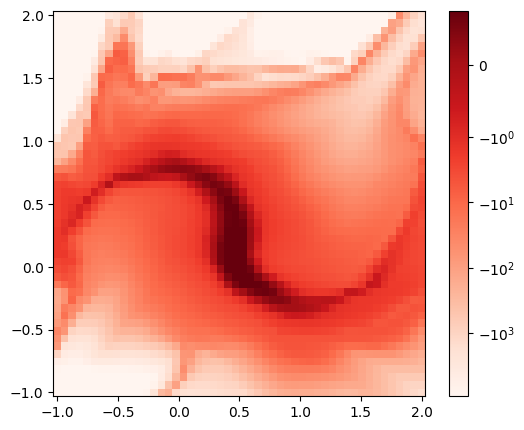

In [220]:
# Plot the densities on the grid
import matplotlib.colors as colors
fig, ax = plt.subplots(figsize=(6, 5))
p = ax.pcolormesh(xx,yy, logpz.reshape(50, 50), norm=colors.SymLogNorm(linthresh=1,
    vmin=np.quantile(logpz,0.1), vmax=np.quantile(logpz,0.99)),
    antialiased=False, cmap='Reds', linewidth=0, rasterized=True)
fig.colorbar(p)